<a href="https://colab.research.google.com/github/Lucas-Buk/Machine-Learning-Metodos-Prob/blob/main/Aula_05_Voting_Bagging_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução**

De forma geral, podemos combinar diversos preditores ou regressores buscando um melhor desempenho do sistema criado. deve-se observar que podemos obter um resultado melhor quando analisado sob determinada métrica mas com uma interpretação não tão direta quando utilziamos um úncio sistema. É uma decisão que merece ser analisada a luz da aplicação.

Em linhas gerais, vamos abordar:

1.   O conceito de ensemble
2.   Majority voting ou Hard voting
3.   Weighted Majority Vote
4.   Soft Voting
5.   Stacking machine learning models
6.   Bagging
7.   Boosting

## **Sistemas de votação e sua modelagem**

Problema geral:

Desejamos rpedizir uma variável aleatória $y \in \{\pm1\}$ a partir de um um cojunto de variáveis aleatórias de entrada $X_i \in \{\pm 1\}$ obtida para cada sistema especilista (em $n$). 

Cada sistema especilista tem uma capacidade de predição de sua respectiva componente $X_i$ com um nível $p \in (0,1)$, trata-se de paorbilidade de que a predição esteja correta: $P(X_i = y) = p_i$

Geralmente temos duas hipóteses simplificadoras:

1.   A variáveis aletaórias $\{ X_i: i \in [n]\}$ são mutuamente independentes quando condicionadas a verdade de $y$.
2.   O sistema é balanceado: $P(y = +1) = P(y =-1) = \dfrac{1}{2}$.






## **Weighted Majority Vote**

Supondo dois classificadores $C_1$ e $C_2$, cada um obtem uma probabildiade associada a estimativa em curso $p_{ij}$ : i-ésima categoria para o j-ésimo classificador, neste exemplo $(2,2)$. Os valores são ponderados por pesos: $w_1$ e $w_2$ correspondente ao Classificador.

Em linhas gerais, o "socre" final pode ser calculado para o casos $(2,2)$:

$\begin{equation}
  Score(X_1) = w_1 p_{11} + w_2 p_{12} \\
  Score(X_2) = w_1 (1 - p_{11}) + w_2 (1- p_{12}) \\
  \end{equation} $

  onde $X_2$ é a negativa de $X_1$.

  Neste caso escolhe-se o valor máximo de Score para identificar a categoria mais provável.

# **Bibliotecas e instalações**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import csv
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math

from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.metrics         import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm           import SVC
from sklearn.linear_model  import LogisticRegression
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import VotingClassifier
from sklearn.ensemble      import BaggingClassifier
from sklearn.ensemble      import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors     import KNeighborsClassifier

from itertools import product
import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold

## **t-SNE**

In [2]:
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Funções proprietárias**

## **Carrega o arquivo e divide entre features e saída**

In [3]:
# Considerando um cojunto de dados onde a última coluna representa o resultado
# Sugestão: deixar as dimenSões configuráveis.
# Estar atento a verificação dimensional para evitar erro.

def CarregaDados(Arquivo):
  dados   =  pd.read_csv(Arquivo, header = None, delimiter=',')
  dataset =  dados.values

  X       =  dataset[1:,:-1].astype(float)
  y       =  dataset[1:,-1].astype(float)

  return X, y

## **Feature selection**

In [4]:
def select_features(X_treino, y_treino, X_teste):
	
	# k determina o número de features que serõa utilizados

	fs = SelectKBest(score_func=f_classif, k='all')
  
	# Determina um modelo de aprendizado consiedrando os dados
	# disponíveis

	fs.fit(X_treino, y_treino)
 
	# Modifica os dados de entrada para treino

	X_treino_fs = fs.transform(X_treino)
 
	# Modifica os dados de entrada para teste

	X_teste_fs = fs.transform(X_teste)
 
	return X_treino_fs, X_teste_fs, fs

## **Ensemble KNN**

In [5]:
def get_voting_KNN():

	# Lista dos modelos de base para a formação do ensemble

	models = list()
	models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
	models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
	models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
	models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
	models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
 
	# Define o tipo de votação de ensemble

	ensemble = VotingClassifier(estimators=models, voting='soft')
	return ensemble

# Dicionário de modelos que serão utilziados no cálculo

def get_models_KNN():

	models = dict()
	models['knn1'] = KNeighborsClassifier(n_neighbors=1)
	models['knn3'] = KNeighborsClassifier(n_neighbors=3)
	models['knn5'] = KNeighborsClassifier(n_neighbors=5)
	models['knn7'] = KNeighborsClassifier(n_neighbors=7)
	models['knn9'] = KNeighborsClassifier(n_neighbors=9)
	models['hard_voting'] = get_voting_KNN()
 
	return models

# Avalia um modelo utilziando validação cruzada

def evaluate_model_KNN(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores


## **Ensemble SVM**

In [6]:
def get_voting_SVC():

	# Lista dos modelos de base para a formação do ensemble

	models = list()
	models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
	models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
	models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
	models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
	models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
 
  # Define o tipo de votação de ensemble

	ensemble = VotingClassifier(estimators=models, voting='soft')
	return ensemble
 
# Dicionário de modelos que serão utilizados no cálculo

def get_models_SVC():
	models = dict()
	models['svm1'] = SVC(probability=True, kernel='poly', degree=1)
	models['svm2'] = SVC(probability=True, kernel='poly', degree=2)
	models['svm3'] = SVC(probability=True, kernel='poly', degree=3)
	models['svm4'] = SVC(probability=True, kernel='poly', degree=4)
	models['svm5'] = SVC(probability=True, kernel='poly', degree=5)
	models['soft_voting'] = get_voting_SVC()
	return models
 
# Avalia um modelo utilziando validação cruzada

def evaluate_model_SVC(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# **Dados**

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-integer

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pós/ML MP/Datasets/diabetes.csv', delimiter=',')

In [9]:
X = df.iloc[:-1,:-1]
X.head()
y = df.iloc[:-1,8]
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Diag, dtype: int64

In [10]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=50)

# **Voting**

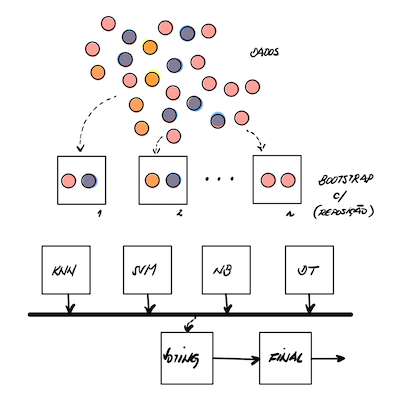

In [11]:
X = np.array(df[['Glicose','Idade']])
y = np.array(df[['Diag']])
y = np.ravel(y,order='C')

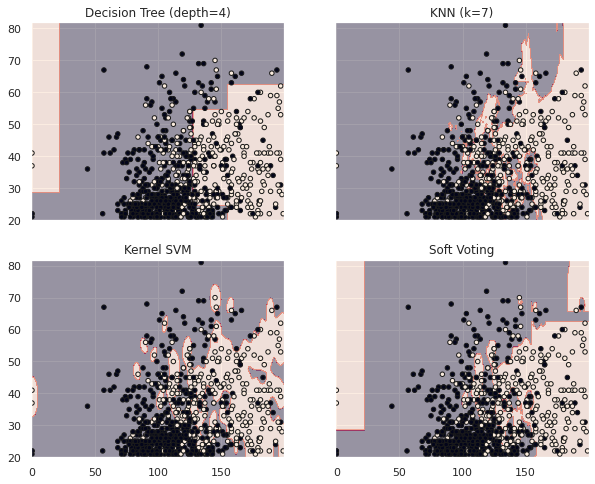

In [12]:
####### Criando os calssificadores

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

####### Treinando os calssificadores

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

####### Regiões de convergência
#
# Cria uma malha para predição do classificador em estudo

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

####### Para cada classificador faz uma predição e compara

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# **Ensemble**

## **Soft Voting**

Para o caso do soft voting ponderado, consideramos sua probabilidade condicional:

$\hat{y} = argmax_i \; \;[p(C_0 \vert X),p(C_1 \vert X), \ldots, p(C_N \vert X)]$

In [13]:
####### Treinando os calssificadores

clf1.fit(X_treino, y_treino)
clf2.fit(X_treino, y_treino)
clf3.fit(X_treino, y_treino)

DT_pred     = clf1.predict(X_teste)
KNN_pred = clf2.predict(X_teste)
SVC_pred    = clf3.predict(X_teste)

Predicao_final =  (DT_pred + KNN_pred + SVC_pred)//3
acuracia = accuracy_score(y_teste, Predicao_final)
acuracia

0.6818181818181818

## **Majority voting ou Hard voting**

No caso da votação por maioria, trata-se de indentificar qual a classe com maior frequência entre os diversos classificadores. Muitas vezes se opta por um critério de que o resulatdo tem que ser superior a $50 \%$ dos votos. Ou pode ser maioria simples.

$\hat{y} = Moda \{C_1(X), C_2(X), \ldots , C_N \}$

In [14]:
####### Criando os calssificadores

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='hard', weights=[2, 1, 2])

clf1.fit(X_treino, y_treino)
clf2.fit(X_treino, y_treino)
clf3.fit(X_treino, y_treino)
eclf.fit(X_treino, y_treino)

Predicao_final = eclf.predict(X_teste)

DT_pred     = clf1.predict(X_teste)
KNN_pred = clf2.predict(X_teste)
SVC_pred    = clf3.predict(X_teste)

acuracia = accuracy_score(y_teste, Predicao_final)
acuracia

0.7207792207792207

# **Bagging**

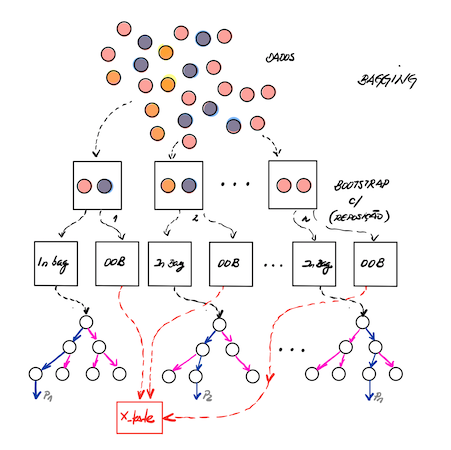

In [15]:
DT_clf = clf1
KNN_clf = clf2
SVC_clf = clf3

KNN_bagging_model = BaggingClassifier(base_estimator=KNN_clf, n_estimators=50, random_state=12)
DT_bagging_model = BaggingClassifier(base_estimator=DT_clf, n_estimators=50, random_state=12)
SVC_bagging_model = BaggingClassifier(base_estimator=SVC_clf, n_estimators=50, random_state=12)

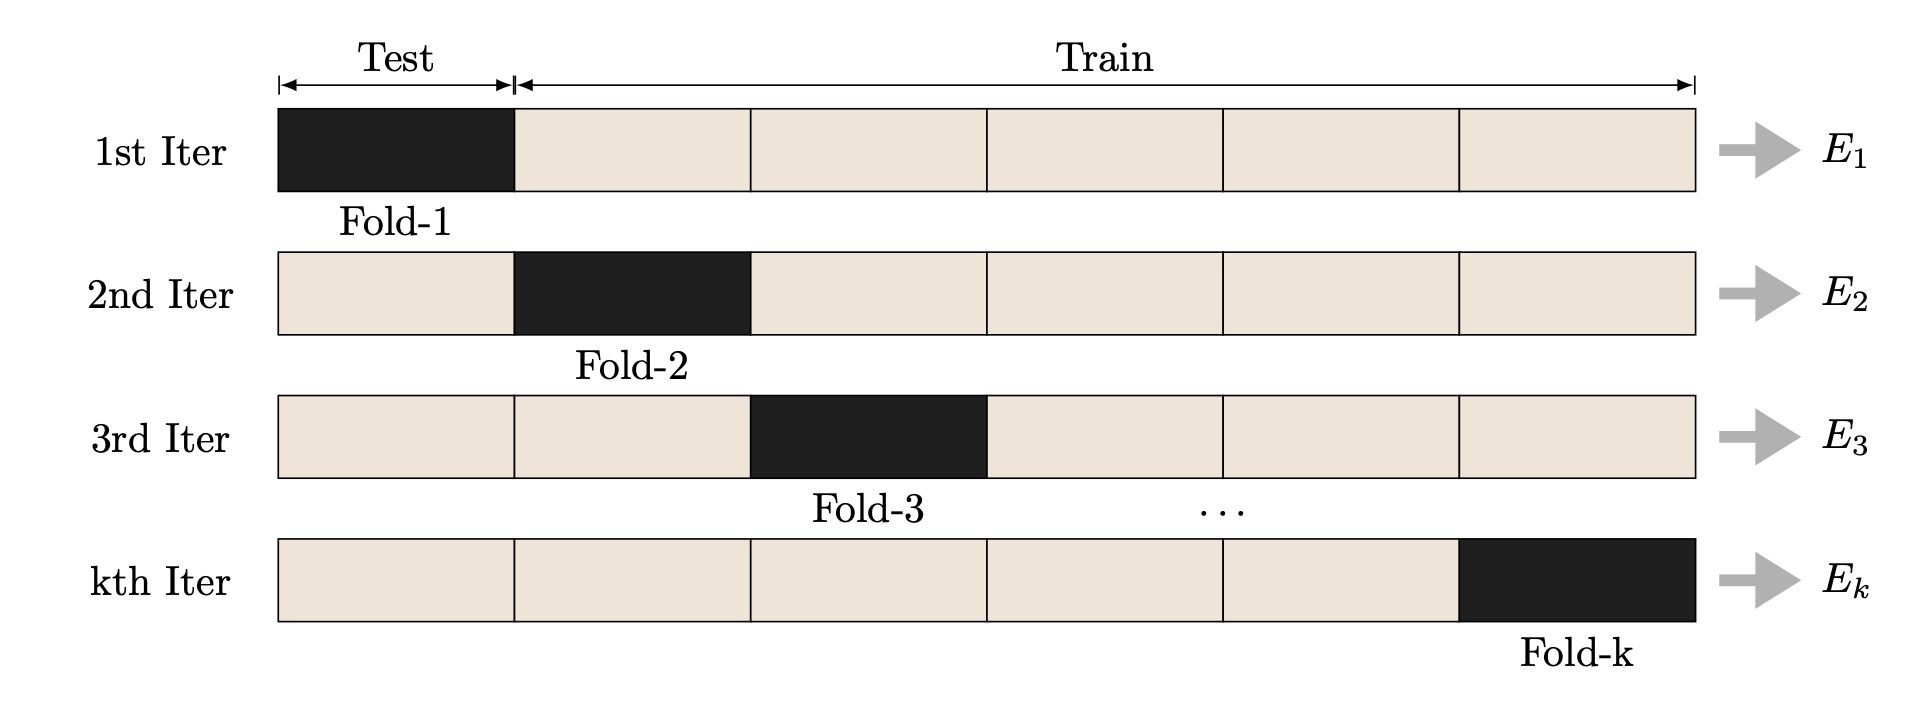

In [16]:
def bagging_ensemble(model):
  k_folds = KFold(n_splits=20, random_state=12, shuffle=True)
  results = cross_val_score(model, X, y, cv=k_folds)
  print(results.mean())

bagging_ensemble(KNN_bagging_model)
bagging_ensemble(DT_bagging_model)
bagging_ensemble(SVC_bagging_model)

0.71221322537112
0.7393387314439946
0.7019905533063426


# **Boosting**

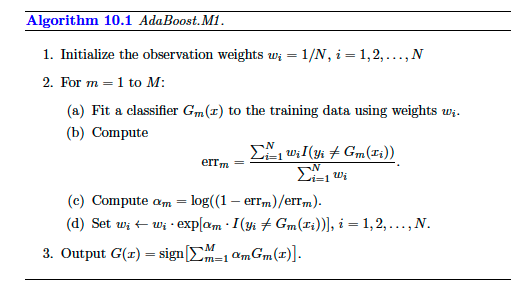

https://tex.stackexchange.com/questions/364629/style-pseudocode-in-latex

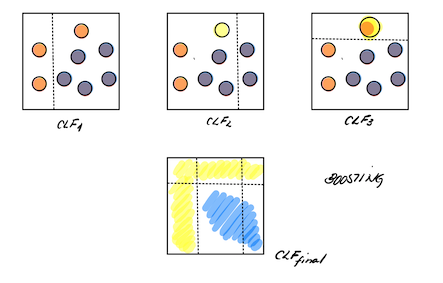

https://www.sciencedirect.com/topics/engineering/adaboost

In [17]:
k_folds = KFold(n_splits=20, random_state=12)

num_estimadores = [20, 40, 60, 80, 100]
for i in num_estimadores:
  ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12)
  results = cross_val_score(ada_boost, X, y, cv=k_folds)
  print(results.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.7491565452091768
0.751855600539811
0.7505735492577598
0.7414304993252361
0.7413967611336033


# **Model Selection**

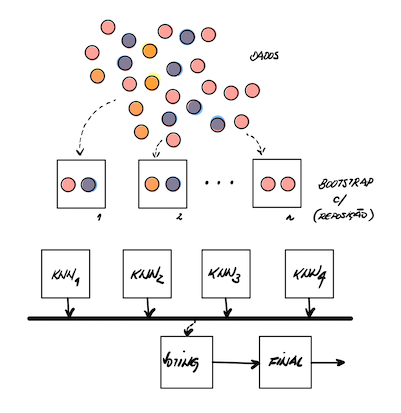

>knn1 0.672 (0.052)
>knn3 0.709 (0.043)
>knn5 0.718 (0.039)
>knn7 0.727 (0.044)
>knn9 0.724 (0.043)
>hard_voting 0.718 (0.036)


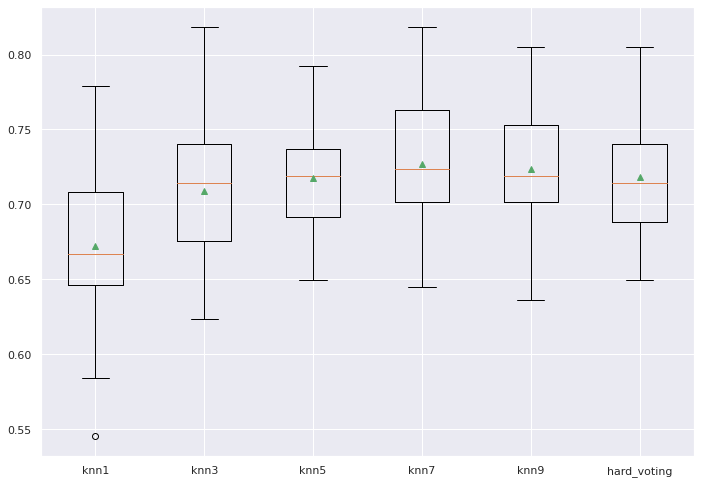

In [18]:
# Cria os modelos KNN de acordo com a definição

models = get_models_KNN()

# Avalia o desempenho dos modelos e armazena os resulatdos para uma determinada métrica

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model_KNN(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
 
# Boxplot acerca do desempenho de cada modelo

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

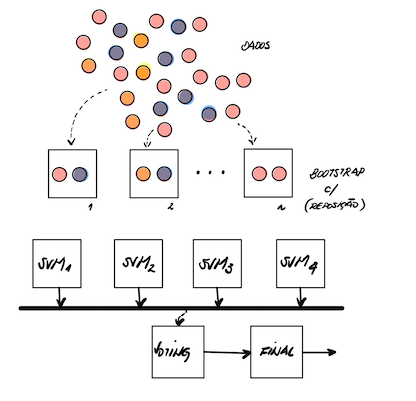

>svm1 0.738 (0.048)
>svm2 0.743 (0.047)
>svm3 0.753 (0.045)
>svm4 0.751 (0.042)
>svm5 0.752 (0.038)
>soft_voting 0.750 (0.045)


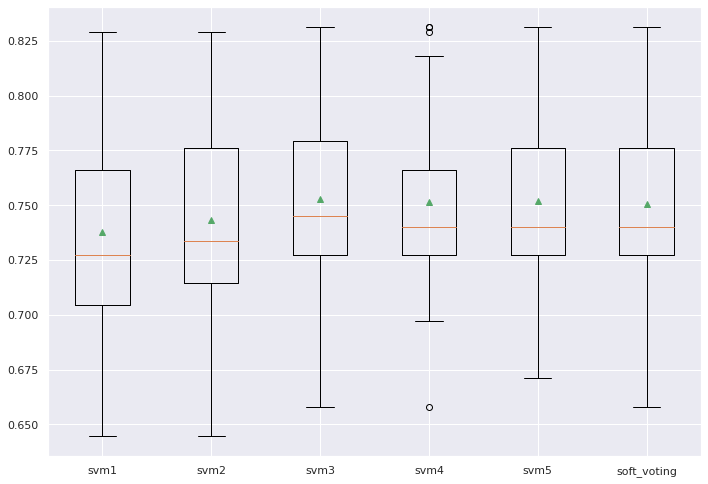

In [19]:
# Cria os modelos KNN de acordo com a definição

models = get_models_SVC()

# Avalia o desempenho dos modelos e armazena os resulatdos para uma determinada métrica

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model_SVC(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
 
# Boxplot acerca do desempenho de cada modelo

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# **Visualização**

https://distill.pub/2016/misread-tsne/#:~:text=A%20second%20feature%20of%20t,effect%20on%20the%20resulting%20pictures.

In [20]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=500)
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.000s...
[t-SNE] Computed neighbors for 768 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 0.953911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.842529
[t-SNE] KL divergence after 500 iterations: 0.529616


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


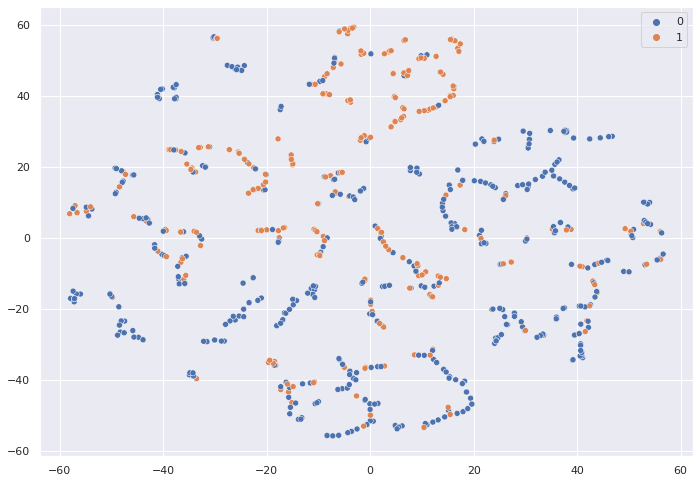

In [22]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')

# **Referências**

In [ ]:
########################################################################################################
# Code source: https://machinelearningmastery.com/                                                     #
#                                                                                                      #
# Modified for class use and explanation about Bagging, voting and boosting by V.C.Parro               #
#                                                                                                      #
# Data base: diabetes                                                                                  #
# License: BSD 3 clause                                                                                #
#                                                                                                      #
########################################################################################################

https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

https://www.kaggle.com/c/titanic/data?select=gender_submission.csv

https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch01/ch01.ipynb

https://datascience.eu/pt/aprendizado-de-maquina/gradient-boosting-o-que-voce-precisa-de-saber/

